In [1]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal

df = pd.read_csv('iris.data', sep=',', header=None)
df.columns = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width','class']

df.head()
pd.unique(df['class'])
df = df.sample(frac=1).reset_index(drop=True)

In [2]:
X = df[['sepal-length', 'sepal-width', 'petal-length', 'petal-width']].to_numpy()
y = df[['class']].to_numpy()
print(X.shape[0])

150


In [3]:
class EMClustering:
    def __init__(self, k, eps):
        self.k = k
        self.eps = eps
        self.t = 0
        
    def fit(self, X):
        self.initialize(X)
        while True:
            self.t += 1
            self.expectation_step(X)
            mus, sigmas, probs = self.maximization_step(X)
            if self.should_break(mus):
                print(f'total steps: {self.t}')
                break
            self.update_params(mus, sigmas, probs)
                
    def initialize(self, X):
        self.clusters = np.split(X, self.k)
        self.mus = []
        self.sigmas = []
        for i in range(self.k):
            cluster = self.clusters[i]
            self.mus.append(cluster.mean(axis=0))
            self.sigmas.append(np.cov(cluster, rowvar=False))
        self.priors = [1/(self.k + 0.0) for i in range(self.k)]
        self.W = np.empty((self.k, X.shape[0]))
    
    def update_params(self, mus, sigmas, priors):
        self.mus = mus
        self.sigmas = sigmas
        self.priors = priors
        
    def should_break(self, mus):
        sum_all = 0;
        for i in range(self.k):
            n = np.linalg.norm(mus[i] - self.mus[i])
            sum_all += n * n
        return True if sum_all <= self.eps else False
    
    def expectation_step(self, X):
        for i in range(self.k):
            for j in range(X.shape[0]):
                self.W[i, j] = (multivariate_normal.pdf(X[j, :], self.mus[i], self.sigmas[i]) * self.priors[i]) / self.total_probability(X[j, :])
                
    def total_probability(self, x):
        total = 0
        for i in range(self.k):
            total += multivariate_normal.pdf(x, self.mus[i], self.sigmas[i]) * self.priors[i]
        return total
    
    def maximization_step(self, X):
        mus = []
        sigmas = []
        priors = []
        for i in range(self.k):
            mus.append(self.re_estimate_mean(i, X))
            sigmas.append(self.re_estimate_cov_matrix(i, X))
            priors.append(self.re_estimate_priors(i, X))
        return mus, sigmas, priors
    
    def re_estimate_mean(self, i, X):
        a = 0;
        b = 0;
        for j in range(X.shape[0]):
            a += X[j, :] * self.W[i, j]
            b += self.W[i, j]
        return a / b
    
    def re_estimate_cov_matrix(self, i, X):
        a = 0;
        b = 0;
        for j in range(X.shape[0]):
            a += self.W[i, j] * np.outer((X[j, :] - self.mus[i]), (X[j, :] - self.mus[i]).transpose())
            b += self.W[i, j]
        return a / b
    
    def re_estimate_priors(self, i, X):
        a = 0;
        for j in range(X.shape[0]):
            a += self.W[i, j]
        return a / X.shape[0]
    
    def predict(self, X):
        W = np.empty((self.k, X.shape[0]))
        for i in range(self.k):
            for j in range(X.shape[0]):
                W[i, j] = (multivariate_normal.pdf(X[j, :], self.mus[i], self.sigmas[i]) * self.priors[i]) / self.total_probability(X[j, :])
        return np.argmax(W, axis=0)
        

In [4]:
emc = EMClustering(3, 0.001)
emc.fit(X)
emc.predict(X)

total steps: 22


array([1, 0, 1, 0, 1, 2, 2, 0, 2, 0, 1, 0, 2, 1, 2, 0, 0, 0, 1, 1, 0, 0,
       0, 2, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 2,
       0, 1, 0, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 2, 1, 0, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 1, 1, 2,
       1, 2, 0, 0, 1, 2, 1, 2, 2, 0, 1, 2, 0, 2, 0, 2, 0, 1, 0, 2, 2, 2,
       2, 0, 0, 2, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 0, 2, 2, 1, 1, 2, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 2, 2, 0, 0, 1, 1, 2, 1, 1, 1])

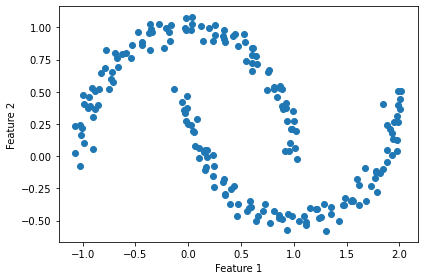

In [6]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons


X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [8]:
emc = EMClustering(2, 0.001)
emc.fit(X)
y_pred = emc.predict(X)

total steps: 1


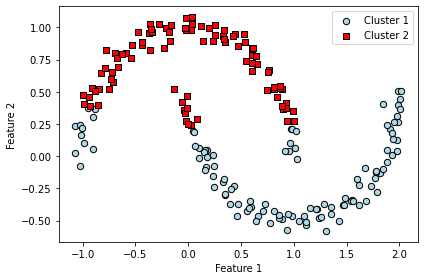

In [9]:
plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='Cluster 1')
plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='Cluster 2')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend()
plt.tight_layout()
plt.show()